<a href="https://colab.research.google.com/github/bonomip/GPU/blob/master/gpu_progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# PROGETTO CLUSTER
---

# 🎬 CUDA setup

In [ ]:
!nvcc --version

In [ ]:
!nvidia-smi

INSTALL AND COMPILE BLAS

In [ ]:
#!git clone https://github.com/xianyi/OpenBLAS.git
#%cd OpenBLAS
#!make
#!make install PREFIX=~/blas
#%cd ..

PYCUDA

In [ ]:
#!pip install pycuda

## [GPU Compute Capability](https://developer.nvidia.com/cuda-gpus)

## NVCC Plugin for Jupyter notebook

*Usage*:


*   Load Extension `%load_ext nvcc_plugin`
*   Mark a cell to be treated as cuda cell
`%%cuda --name example.cu --compile false`

**NOTE**: The cell must contain either code or comments to be run successfully. It accepts 2 arguments. `-n | --name` - which is the name of either CUDA source or Header. The name parameter must have extension `.cu` or `.h`. Second argument -c | --compile; default value is false. The argument is a flag to specify if the cell will be compiled and run right away or not. It might be usefull if you're playing in the main function

*  We are ready to run CUDA C/C++ code right in your Notebook. For this we need explicitly say to the interpreter, that we want to use the extension by adding `%%cu` at the beginning of each cell with CUDA code. 




In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

In [ ]:
%load_ext nvcc_plugin

In [ ]:
#%pip install --target=$nb_path pycuda

In [ ]:
!mkdir -p src

In [ ]:
#@title Bash setup
%%writefile /root/.bashrc

# If not running interactively, don't do anything
[ -z "$PS1" ] && return

# don't put duplicate lines in the history. See bash(1) for more options
# ... or force ignoredups and ignorespace
HISTCONTROL=ignoredups:ignorespace

# append to the history file, don't overwrite it
shopt -s histappend

# for setting history length see HISTSIZE and HISTFILESIZE in bash(1)
HISTSIZE=10000
HISTFILESIZE=20000

# check the window size after each command and, if necessary,
# update the values of LINES and COLUMNS.
shopt -s checkwinsize

# make less more friendly for non-text input files, see lesspipe(1)
[ -x /usr/bin/lesspipe ] && eval "$(SHELL=/bin/sh lesspipe)"

PS1='\[\033[01;34m\]\w\[\033[00m\]\$ '

# enable color support of ls and also add handy aliases
if [ -x /usr/bin/dircolors ]; then
    test -r ~/.dircolors && eval "$(dircolors -b ~/.dircolors)" || eval "$(dircolors -b)"
    alias ls='ls --color=auto'
    #alias dir='dir --color=auto'
    #alias vdir='vdir --color=auto'

    alias grep='grep --color=auto'
    alias fgrep='fgrep --color=auto'
    alias egrep='egrep --color=auto'
fi

# some more ls aliases
alias ll='ls -lF'
alias la='ls -A'
alias l='ls -CF'

# path setup
export PATH="./:/usr/local/cuda/bin:$PATH"

## 📦 Packages

C pkgs

In [ ]:
%%writefile src/common.h

#include <sys/time.h>
#include <stdio.h>

#ifndef _COMMON_H
#define _COMMON_H

#define CHECK(call)                                                            \
{                                                                              \
    const cudaError_t error = call;                                            \
    if (error != cudaSuccess)                                                  \
    {                                                                          \
        fprintf(stderr, "Error: %s:%d, ", __FILE__, __LINE__);                 \
        fprintf(stderr, "code: %d, reason: %s\n", error,                       \
                cudaGetErrorString(error));                                    \
    }                                                                          \
}

#define CHECK_CUBLAS(call)                                                     \
{                                                                              \
    cublasStatus_t err;                                                        \
    if ((err = (call)) != CUBLAS_STATUS_SUCCESS)                               \
    {                                                                          \
        fprintf(stderr, "Got CUBLAS error %d at %s:%d\n", err, __FILE__,       \
                __LINE__);                                                     \
        exit(1);                                                               \
    }                                                                          \
}

#define CHECK_CURAND(call)                                                     \
{                                                                              \
    curandStatus_t err;                                                        \
    if ((err = (call)) != CURAND_STATUS_SUCCESS)                               \
    {                                                                          \
        fprintf(stderr, "Got CURAND error %d at %s:%d\n", err, __FILE__,       \
                __LINE__);                                                     \
        exit(1);                                                               \
    }                                                                          \
}

#define CHECK_CUFFT(call)                                                      \
{                                                                              \
    cufftResult err;                                                           \
    if ( (err = (call)) != CUFFT_SUCCESS)                                      \
    {                                                                          \
        fprintf(stderr, "Got CUFFT error %d at %s:%d\n", err, __FILE__,        \
                __LINE__);                                                     \
        exit(1);                                                               \
    }                                                                          \
}

#define CHECK_CUSPARSE(call)                                                   \
{                                                                              \
    cusparseStatus_t err;                                                      \
    if ((err = (call)) != CUSPARSE_STATUS_SUCCESS)                             \
    {                                                                          \
        fprintf(stderr, "Got error %d at %s:%d\n", err, __FILE__, __LINE__);   \
        cudaError_t cuda_err = cudaGetLastError();                             \
        if (cuda_err != cudaSuccess)                                           \
        {                                                                      \
            fprintf(stderr, "  CUDA error \"%s\" also detected\n",             \
                    cudaGetErrorString(cuda_err));                             \
        }                                                                      \
        exit(1);                                                               \
    }                                                                          \
}

cudaEvent_t start, stop;

inline void tic(){
  cudaEventCreate(&start);
	cudaEventCreate(&stop);
  CHECK(cudaEventRecord(start));
}

inline void toc(){
  CHECK(cudaEventRecord(stop));
  CHECK(cudaEventSynchronize(stop));
  
  float milliseconds;
  CHECK(cudaEventElapsedTime(&milliseconds, start, stop));
  printf("    elapsed time: %.5f (sec)\n", milliseconds / 1000.0);
}

inline double seconds() {
    struct timeval tp;
    struct timezone tzp;
    int i = gettimeofday(&tp, &tzp);
    return ((double)tp.tv_sec + (double)tp.tv_usec * 1.e-6);
}

inline void device_name() {
    // set up device
    int dev = 0;
    cudaDeviceProp deviceProp;
    CHECK(cudaGetDeviceProperties(&deviceProp, dev));
    printf("device %d: %s\n", dev, deviceProp.name);
    CHECK(cudaSetDevice(dev));
}

typedef unsigned long ulong;
typedef unsigned int uint;

#endif // _COMMON_H

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
import numpy
import numba
import time
import os

## ARGS
# 0 = name of function
# 1 .. n, positional arguments for function

def dispatcher(f, args):
  if len(args) == 1 :
    return f();
  if len(args) == 2 :
    return f(args[1]);
  if len(args) == 3 :
    return f(args[1], args[2]);
  if len(args) == 4 :
    return f(args[1], args[2], args[3]);
  if len(args) == 5 :
    return f(args[1], args[2], args[3], args[4]);

def avg_time_of(f, args, r=3):

  t = 0
  for i in range(0, int(r-1)):
    tic()
    dispatcher(f, args)
    t += toc(False)
  
  tic()
  theta = dispatcher(f, args)
  t += toc(False)

  print( "Average time of %s: \t\t %f seconds.\n" %(args[0], (t/r)) )
  
  return theta


def get_chunks_of_size_until_empty(size, n):
  #function that return n as an array of chunks
  n_chunks = math.ceil(n/size)

  chunks = [0] * (n_chunks)

  for i in range(0, n_chunks-1):
      chunks[i] = size

  if(n_chunks == n/size):
      chunks[n_chunks-1] = size
  else:
      chunks[n_chunks-1] = int(n-numpy.sum(chunks))

  return chunks

def TicTocGenerator():
  # Generator that returns time differences
  ti = 0           # initial time
  tf = time.time() # final time
  while True:
    ti = tf
    tf = time.time()
    yield tf-ti # returns the time difference

TicToc = TicTocGenerator() 

def toc(tempBool=True):
  # Prints the time difference yielded by generator instance TicToc
  tempTimeInterval = next(TicToc)
  if tempBool:
    print( "Elapsed time: %f seconds." %tempTimeInterval )
  return tempTimeInterval

def tic():
  # Records a time in TicToc, marks the beginning of a time interval
  toc(False)

# instance creation
def rand_blobs(n, d, k=3, std=1, rstate=None, standard=True, display=True, threeD=False): 
  X, l = make_blobs(n_samples=n, centers=k, n_features=d, cluster_std=std, random_state=rstate)
  if standard:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
  W = euclidean_distances(X, X)

  # plot
  if display:
    plot_blobs(X,l,threeD)
  return X, l, W, n

def histogram(theta, nbins=None, verb=True):
  if nbins is None:
    nbins = len(theta)
  binsLIM = numpy.linspace(0,2*numpy.pi,nbins)
  hist, bins = numpy.histogram(theta, binsLIM)

  if verb:
    print('Data size : %d' %len(theta))
    print('Num bins  : %d' %nbins)

  return hist, bins 

def plot_circle(theta, l=None, radius=500):
  """
    Produce a plot with the locations of all poles and zeros
  """

  x = numpy.cos(theta)
  y = numpy.sin(theta)

  fig = go.Figure()
  fig.add_shape(type="circle", xref="x", yref="y", x0=-1, y0=-1, x1=1, y1=1, line=dict(color="black", width=1))
  
  if l is None:
    fig.add_trace(go.Scatter(x=x, y=y,
          mode='markers',
          marker_symbol='circle',
          marker_size=10))
  else:
    ul = numpy.unique(l)
    cols = list(range(len(ul)))
    for c,u in zip(cols,ul):
      idx = numpy.where(u == l)
      fig.add_trace(go.Scatter(x=x[idx], y=y[idx],
          mode='markers',
          marker_symbol='circle',
          marker_color=cols[c], 
          marker_line_color=cols[c],
          marker_line_width=0, 
          marker_size=10))
  
  M = 1.05
  fig.update_xaxes(title='', range=[-M, M])
  fig.update_yaxes(title='', range=[-M, M])
  fig.update_layout(title='clusters', width=radius, height=radius)
  fig.show()

def plot_hist(hist, bins, mode=0, smooth_wlen=None):

  if mode==0:
    mode_line = 'lines'
  elif mode == 1:
    mode_line = 'markers'
  else:
    mode_line = 'lines+markers'
  
  if smooth_wlen is not None:
    hist = smooth(hist, window_len=smooth_wlen, window='hanning')

  figh = go.Figure(data=go.Scatter(x=bins, y=hist, mode=mode_line))
  figh.show()

def plot_blobs(X, labels=None, threeD=False, doPCA=True, sizex=1):

  if threeD:
    if PCA:
      pca = PCA(n_components=3)
      components = pca.fit_transform(X)
    else:
      components = X[:,0:3]  
    if labels is None:
      fig = px.scatter_3d(components, x=0, y=1, z=2, title='Blobs 3D',
                          labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
    else:
      fig = px.scatter_3d(components, x=0, y=1, z=2, color=labels, title='Blobs 3D',
                          labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
  else:
    if doPCA:
      pca = PCA(n_components=2)
      components = pca.fit_transform(X)
    else:
      components = X[:,0:2]  
    if labels is None:
      fig = px.scatter(components, x=0, y=1, title='Blobs 2D', labels={'0': 'PC 1', '1': 'PC 2'})
    else:
      fig = px.scatter(components, x=0, y=1, title='Blobs 2D', color=labels, labels={'0': 'PC 1', '1': 'PC 2'})
  
  fig.update_layout(
    width = 800*sizex,
    height = 800*sizex,
    title = "fixed-ratio axes")
  fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1)
  fig.show()


def kmeans(X, k, niter=300, rstate=0, n_init=10):
  kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=niter, random_state=rstate)
  kmeans.fit(X)

  return kmeans.labels_, kmeans.n_iter_, kmeans.inertia_ 

# 🪣 CSN Algorithms

In [ ]:
ROUNDS = 32

X, l, W_2, n = rand_blobs(10, d=28*28, k=5, std=5, standard=False, display=False)
W_2 = pairwise_distances(X,X, metric='cosine')

X, l, W, n = rand_blobs(10000, d=28*28, k=5, std=5, standard=False, display=False)
W = pairwise_distances(X,X, metric='cosine')

## CPU - Legacy

In [ ]:
@numba.jit
def CSN_LEGACY(W, eps=0.01, theta0=None, normalize=True, seed=1):
  
  # general vars
  PI = numpy.pi #numpy.pi
  n = W.shape[0]

  # param check
  if normalize:
    W = W / numpy.linalg.norm(W) #linear algebra norm
  if theta0 is None: # if theta is not defined
    numpy.random.seed(seed)
    theta = 2*PI*numpy.random.rand(n)  # init. values in [0, 2*PI] # cudarandom
  else:
    theta = theta0

  # preliminar computations 
  sin_t = numpy.sin(theta)
  cos_t = numpy.cos(theta)
  A = numpy.dot(W, cos_t)
  B = numpy.dot(W, sin_t)

  # main loop
  ok = True
  rounds = 0
  global ROUNDS
  while rounds < ROUNDS: #replace it with <<ok>>
    ok = False
    rounds += 1
    nchanges = 0
    # loop on angles
    for i in range(n):
      old = theta[i]

      # change i-th theta
      theta[i] = numpy.arctan(B[i]/A[i])    # within [-PI/2, PI/2]

      if A[i] >= 0:
        theta[i] += PI
      elif B[i] > 0:
        theta[i] += 2*PI

      # update Ak & Bk by elementwise product and diff
      A += numpy.multiply(W[i,:], numpy.repeat(numpy.cos(theta[i]) - numpy.cos(old), n))
      B += numpy.multiply(W[i,:], numpy.repeat(numpy.sin(theta[i]) - numpy.sin(old), n)) 

      if min(abs(old-theta[i]),abs(2*PI-old+theta[i])) > eps:
        ok = True
        nchanges += 1

  print("rounds="+str(rounds))

  return theta

In [ ]:
%%capture
avg_time_of(CSN_LEGACY, ["CSN Legacy", W_2])

In [ ]:
avg_time_of(CSN_LEGACY, ["CSN Legacy", W])

## CPU - Optimized

In [ ]:
import numpy

@numba.jit
def CSN_CPU(W, eps=0.01, seed=1):
  n = W.shape[0]
  PI = numpy.pi
  
  # W is reshaped in a vector using the column major order
  # than the norm-2 (euclidean norm) is computed
  # this is Frobenius norm
  W = W / numpy.linalg.norm(W) # Frobenius_norm(W)
  
  numpy.random.seed(seed)
  theta = 2*PI*numpy.random.rand(n)
  
  sin_t = numpy.sin(theta)
  cos_t = numpy.cos(theta)
  
  A = numpy.dot(W, cos_t) # W @ cos_t
  B = numpy.dot(W, sin_t) # W @ sin_t

  ok = True
  rounds = 0
  global ROUNDS
  while rounds < ROUNDS: #replace it with <<ok>>
    ok = False
    rounds += 1
    nchanges = 0

    # loop on angles
    for i in range(n):
      theta, A, B, ok, nchanges = loop_fun(i, theta, A, B, eps, W, n, nchanges, PI, ok)

  print("rounds="+str(rounds))

  return theta

@numba.jit
def loop_fun(i, theta, A, B, eps, W, n, nchanges, PI, ok):
  old = theta[i]

  # change i-th theta
  theta[i] = numpy.arctan(B[i]/A[i])    # within [-PI/2, PI/2]
  
  if A[i] >= 0:
    theta[i] += PI
  elif B[i] > 0:
    theta[i] += 2*PI

  # update Ak & Bk by elementwise product and diff
  A, B = updateAB(A, B, W, i, theta, old, n)

  if min(abs(old-theta[i]),abs(2*PI-old+theta[i])) > eps:
    ok = True
    nchanges += 1

  return theta, A, B, ok, nchanges

@numba.jit
def updateAB(A, B, W, i, theta, old, n):
  # A += W[i,:] * ( numpy.cos(theta[i]) - numpy.cos(old) )
  A += numpy.multiply(W[i,:], numpy.cos(theta[i]) - numpy.cos(old))
  B += numpy.multiply(W[i,:], numpy.sin(theta[i]) - numpy.sin(old)) 
  return A, B


In [ ]:
%%capture
avg_time_of(CSN_CPU, ["CSN CPU", W_2])

In [ ]:
avg_time_of(CSN_CPU, ["CSN CPU", W])

## GPU - CUDA C V_1

In [ ]:
%%writefile src/const_v1.h

#ifndef VARIABLES
#define VARIABLES

#define N 10000
#define TOW_TIMES_PI 2*M_PI
#define BLOCK_SIZE 128
#define EPS 0.1
#define ROUNDS 32

#endif

In [ ]:
%%writefile src/structs_v1.h

#ifndef STRUCTS
#define STRUCTS

struct gtv { //gpu theta values
    float *theta, *sin_theta, *cos_theta;
};

struct abv { //gpu A B values
    float *A, *B;
};

#endif

In [ ]:
%%writefile src/thetaModule_v1.cu

#include <stdio.h>
#include <stdlib.h>
#include "../src/common.h"
#include "../src/structs_v1.h"
#include "../src/const_v1.h"
#include <cuda.h>
#include <curand.h>


__global__ void Kernel_1(float *theta, float* cosTheta, float* sinTheta)
{
  unsigned int tid = threadIdx.x + blockIdx.x * blockDim.x;
  
  if (tid < N)
  {
    float x = TOW_TIMES_PI* theta[tid];
    theta[tid] = x;
    cosTheta[tid] = cos(x);
    sinTheta[tid] = sin(x);
  }
}

gtv theta_sin_cos()
{
  //# curand
  curandGenerator_t gen;
  
  float *dTheta, *dSinTheta, *dCosTheta;

  /* # CREATE RANDOM VECTOR # */

  /* Allocate n floats on device */
  CHECK(cudaMalloc((void **) & dTheta, N*sizeof ( float )));
  
  /* Create pseudo - random number generator */
  CHECK_CURAND(curandCreateGenerator (&gen, CURAND_RNG_PSEUDO_DEFAULT));
  
  /* Set seed */
  CHECK_CURAND(curandSetPseudoRandomGeneratorSeed(gen, 1234ULL));
  
  /* Generate N floats on device */
  CHECK_CURAND(curandGenerateUniform (gen , dTheta, N));
  
  /* # CALL KERNEL 1 # */

  /* Allocate n floats on device */
  CHECK(cudaMalloc((void **) & dCosTheta, N*sizeof ( float )));
  /* Allocate n floats on device */
  CHECK(cudaMalloc((void **) & dSinTheta, N*sizeof ( float )));

  dim3 block(BLOCK_SIZE, 1, 1);
	dim3 grid((N + block.x - 1) / block.x, 1, 1);

  //printf("Strating Kernel 1 -- N: %d, GRID_SIZE: %d, BLOCK_SIZE: %d\n", N, grid.x, BLOCK_SIZE);
  Kernel_1<<<block, grid>>>(dTheta, dCosTheta, dSinTheta);

  struct gtv s;
  s.theta = dTheta;
  s.sin_theta = dSinTheta;
  s.cos_theta = dCosTheta;

  CHECK_CURAND(curandDestroyGenerator(gen));

  return s;
}

In [ ]:
%%writefile src/matrixModule_v1.cu

#include <stdio.h>
#include <stdlib.h>
#include "../src/common.h"
#include <cuda.h>
#include "cublas_v2.h"
#include "../src/const_v1.h"

float *matrix_norm(cublasHandle_t handle, float *matrix)
{
  float *d_matrix;
  float norm;
  int n = N*N;
  
  CHECK(cudaMalloc(&d_matrix, N*N*sizeof(float)));
  CHECK_CUBLAS(cublasSetVector(N*N, sizeof(float), matrix, 1, d_matrix, 1));

  CHECK_CUBLAS(cublasSnrm2(handle, n, d_matrix, 1, &norm));
  
  norm = 1/norm;
  CHECK_CUBLAS(cublasSscal(handle, n, &norm, d_matrix, 1));

  return d_matrix;
}

In [ ]:
%%writefile src/abModule_v1.cu

#include <stdio.h>
#include <stdlib.h>
#include "../src/common.h"
#include "../src/structs_v1.h"
#include <cuda.h>
#include "cublas_v2.h"
#include "../src/const_v1.h"

  // only works on nvcc 11.2, here is 11.1
  //cudaMallocAsync(&d_A, N*sizeof(float), a_stream);

abv ab_compute(cublasHandle_t a_handle, cublasHandle_t b_handle, float *d_W, float *d_cTheta, float *d_sTheta)
{
  float *d_A, *d_B;
  float alpha = 1.0f;
  float beta = 0.0f;

  CHECK(cudaMalloc((void **)&d_A, N*sizeof(float)));

  CHECK_CUBLAS(cublasSgemv(a_handle, CUBLAS_OP_N,
     N, N, &alpha, d_W, N, d_cTheta, 1,
    &beta, d_A, 1));

  //compute B

  CHECK(cudaMalloc((void **)&d_B, N*sizeof(float)));

  CHECK_CUBLAS(cublasSgemv(b_handle, CUBLAS_OP_N,
     N, N, &alpha, d_W, N, d_sTheta, 1,
    &beta, d_B, 1));

  CHECK(cudaDeviceSynchronize());

  struct abv s;

  s.A = d_A;
  s.B = d_B;

  return s;
}

In [ ]:
%%writefile src/abUpdateModule_v1.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include "../src/common.h"
#include <cuda.h>
#include "cublas_v2.h"
#include "../src/const_v1.h"

void ab_update(cublasHandle_t a_handle, cublasHandle_t b_handle, float *d_W, int offset, float *d_A, float *d_B, float theta, float old)
{
  float s_alpha, c_alpha;

  s_alpha = sin(theta) - sin(old);
  c_alpha = cos(theta) - cos(old);

  CHECK_CUBLAS(cublasSaxpy(a_handle, N, &c_alpha, d_W+(N*offset), 1, d_A, 1));
  CHECK_CUBLAS(cublasSaxpy(b_handle, N, &s_alpha, d_W+(N*offset), 1, d_B, 1));

  return;
}

In [ ]:
%%writefile src/cudaMain_v1.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include "../src/matrixModule_v1.cu"
#include "../src/thetaModule_v1.cu"
#include "../src/abModule_v1.cu"
#include "../src/abUpdateModule_v1.cu"
#include "../src/structs_v1.h"
#include "../src/const_v1.h"

/*
* MAIN
*/

int main()
{
  float *d_theta, *d_sTheta, *d_cTheta, *d_W, *d_A, *d_B;
  cublasHandle_t a_handle, b_handle;
  float *matrix;
  struct gtv t;
  struct abv ab;

  CHECK_CUBLAS(cublasCreate(&a_handle));
  CHECK_CUBLAS(cublasCreate(&b_handle));

  //compute theta, sin, cos
  t = theta_sin_cos();
  d_theta = t.theta;
  d_cTheta = t.cos_theta; 
  d_sTheta = t.sin_theta;

  //create matrix
  matrix = (float *) malloc(sizeof(float) * N*N);
  for(long i=0;i<N*N;i++)
    matrix[i]=rand()%100;

  //normalize matrix
  d_W = matrix_norm(a_handle, matrix);

  CHECK(cudaDeviceSynchronize());

  free(matrix);

  //compute A B
  ab = ab_compute(a_handle, b_handle, d_W, d_cTheta, d_sTheta);
  d_A = ab.A;
  d_B = ab.B;

  //loop function
  int ok = 1;
  int rounds = 0;
  float theta, old, a, b, x, y, min;

  while(ok)
  {
    ok=0;
    rounds++;
    
    for(int i=0; i < N; i++)
    {  
        CHECK(cudaMemcpy(&old, d_theta+i, sizeof(float), cudaMemcpyDeviceToHost));
        CHECK(cudaMemcpy(&a, d_A+i, sizeof(float), cudaMemcpyDeviceToHost));
        CHECK(cudaMemcpy(&b, d_B+i, sizeof(float), cudaMemcpyDeviceToHost));

        theta = atan(b/a);

        if(a >= 0) theta += M_PI; else if (b > 0) theta += 2*M_PI;

        CHECK(cudaMemcpy(d_theta+i, &theta, sizeof(float), cudaMemcpyHostToDevice));

        x = abs(old-theta);
        y = abs(2*M_PI-old+theta);
        min = x < y ? x : y; 

        if ( min > EPS )
          ok = 1;

        ab_update(a_handle, b_handle, d_W, i, d_A, d_B, theta, old); 
    }

    if(rounds >= ROUNDS) ok = 0; else ok = 1;
  }
}

In [ ]:
!nvcc -o /content/main_v1 /content/src/cudaMain_v1.cu -lcurand -lcublas
#!!nvprof ./main_v1
#!nvprof --analysis-metrics -o main.nvprof ./main_v1

In [ ]:
%%capture
avg_time_of(os.system, ["Cuda V1", "./main_v1"])

In [ ]:
avg_time_of(os.system, ["Cuda V1", "./main_v1"])

## GPU - CUDA C V_2

In [ ]:
%%writefile src/cudaMain_v2.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <curand.h>
#include "cublas_v2.h"
#include <cuda.h>
#include "../src/common.h"

#define N 10000
#define TOW_TIMES_PI 2*M_PI
#define BLOCK_SIZE 128
#define EPS 0.1
#define ROUNDS 32


__global__ void Kernel_1(float *thetas)
{
  unsigned int tid = threadIdx.x + blockIdx.x * blockDim.x;
  
  if (tid < N)
  {
    float x = TOW_TIMES_PI* thetas[tid];
    thetas[tid] = x;
    thetas[tid+N] = cos(x);
    thetas[tid+(N*2)] = sin(x);
  }
}

/*
* MAIN
*/

int main()
{
  float *d_thetas, *d_W, *d_AB, *theta, norm, *matrix, *ab;
  cublasHandle_t a_handle, b_handle;
  cudaStream_t stream0, stream1, stream2;
  curandGenerator_t gen;
  int n = N*N;
  float alpha = 1.0f;
  float beta = 0.0f;

  //define grid and block for kernel 1
  dim3 block(BLOCK_SIZE, 1, 1);
	dim3 grid((N + block.x - 1) / block.x, 1, 1);

  //allocate host memory
  theta = (float*) malloc(sizeof(float)*N);
  matrix = (float *) malloc(sizeof(float) * N*N);
  ab = (float*) malloc(sizeof(float)*2);

  //create matrix on host // JUST FOR DEBUG
  for(long i=0;i<N*N;i++)
    matrix[i]=rand()%100;

  //Allocate pinned memeory
  // pack this in only one malloc
  CHECK(cudaMalloc((void **) &d_thetas, 3*N*sizeof(float))); 
  CHECK(cudaMalloc((void **) &d_W, N*N*sizeof(float)));
  CHECK(cudaMalloc((void **)&d_AB, 2*N*sizeof(float)));
  
  //Create API Handlers
  CHECK_CURAND(curandCreateGenerator (&gen, CURAND_RNG_PSEUDO_DEFAULT));
  CHECK_CUBLAS(cublasCreate(&a_handle));
  CHECK_CUBLAS(cublasCreate(&b_handle));

  //Create Streams
  CHECK(cudaStreamCreate(&stream0));
  CHECK(cudaStreamCreate(&stream1));
  CHECK(cudaStreamCreate(&stream2));

  //bind streams to CUDA API handlers
  CHECK_CURAND(curandSetStream(gen, stream2));
  CHECK_CUBLAS(cublasSetStream(a_handle, stream1));
  CHECK_CUBLAS(cublasSetStream(b_handle, stream0));

  //set up curand gen seed
  CHECK_CURAND(curandSetPseudoRandomGeneratorSeed(gen, 1234ULL));

  //load matrix on GPU
  CHECK_CUBLAS(cublasSetMatrixAsync(N, N, sizeof(float), matrix, N, d_W, N, stream1));
  
  //compute theta, sin, cos
  //try to create uniform inside kernel
  CHECK_CURAND(curandGenerateUniform(gen , d_thetas, N));
  Kernel_1<<<block, grid, 0, stream2>>>(d_thetas);

  //normalize matrix
  CHECK_CUBLAS(cublasSnrm2(a_handle, n, d_W, 1, &norm));
  norm = 1/norm;
  CHECK_CUBLAS(cublasSscal(a_handle, n, &norm, d_W, 1));

  CHECK(cudaDeviceSynchronize());

  //copy data back to HOST
  CHECK(cudaMemcpyAsync(theta, d_thetas, sizeof(float)*N, cudaMemcpyDeviceToHost, stream2));

  //compute A and B
  CHECK_CUBLAS(cublasSgemv(a_handle, CUBLAS_OP_N,
     N, N, &alpha, d_W, N, d_thetas+N, 1,
    &beta, d_AB, 2));
  CHECK_CUBLAS(cublasSgemv(b_handle, CUBLAS_OP_N,
     N, N, &alpha, d_W, N, d_thetas+(N*2), 1,
    &beta, d_AB+1, 2));

  int ok = 1;
  int rounds = 0;
  float old, x, y, min;

  while(ok)
  {
    ok=0;
    rounds++;

    for(int i=0; i < N; i++)
    {  
      //only one memcopy of 2*sizeof(float)
        CHECK(cudaMemcpy(ab, d_AB+(i*2), 2*sizeof(float), cudaMemcpyDeviceToHost));
      
        old = theta[i];
        theta[i] = atan(ab[1]/ab[0]);

        if(ab[0] >= 0) theta[i] += M_PI; else if (ab[1] > 0) theta[i] += TOW_TIMES_PI;

        x = abs(old-theta[i]);
        y = abs(TOW_TIMES_PI-old+theta[i]);
        min = x < y ? x : y; 

        if(min > EPS) ok = 1;

        float s_alpha = sin(theta[i]) - sin(old);
        float c_alpha = cos(theta[i]) - cos(old);

        int off = N*i;
        CHECK_CUBLAS(cublasSaxpy(a_handle, N, &c_alpha, d_W+off, 1, d_AB, 2));
        CHECK_CUBLAS(cublasSaxpy(b_handle, N, &s_alpha, d_W+off, 1, d_AB+1, 2));
    }

    if(rounds >= ROUNDS) ok = 0; else ok = 1;
  }

  free(ab);
  free(matrix);
  free(theta);
  CHECK(cudaFree(d_thetas));
  CHECK(cudaFree(d_W));
  CHECK(cudaFree(d_AB));
  CHECK_CURAND(curandDestroyGenerator(gen));
  CHECK(cudaDeviceReset());
  return 0;
}

In [ ]:
%%writefile src/matrix_v2.cu

#define N 10000

int main()
{
  //create matrix
  float *matrix;
  matrix = (float *) malloc(sizeof(float) * N*N);
  for(long i=0;i<N*N;i++)
    matrix[i]=rand()%100;
}

In [ ]:
!nvcc -o /content/matrix_v2 /content/src/matrix_v2.cu
!nvcc -o /content/main_v2 /content/src/cudaMain_v2.cu -lcurand -lcublas
#!nvprof ./main_v2
#!nvprof --export-profile main.nvprof ./main_v2

In [ ]:
%%capture
avg_time_of(os.system, ["Matrix", "./matrix_v2"])
avg_time_of(os.system, ["Cuda V2", "./main_v2"])

In [ ]:
avg_time_of(os.system, ["Matrix", "./matrix_v2"])
avg_time_of(os.system, ["Cuda V2", "./main_v2"])

## GPU - CUDA C + BLAS

In [ ]:
%%writefile src/cudaHybrid.cu

#include <cblas.h>
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <curand.h>
#include "cublas_v2.h"
#include <cuda.h>
#include "../src/common.h"

#define N 10000
#define TOW_TIMES_PI 2*M_PI
#define BLOCK_SIZE 128
#define EPS 0.1
#define ROUNDS 32

__global__ void Kernel_1(float *thetas)
{
  unsigned int tid = threadIdx.x + blockIdx.x * blockDim.x;
  
  if (tid < N)
  {
    float x = TOW_TIMES_PI* thetas[tid];
    thetas[tid] = x;
    thetas[tid+N] = cos(x);
    thetas[tid+(N*2)] = sin(x);
  }
}

/*
* MAIN
*/

int main()
{
  float *d_thetas, *d_W, *d_AB, *theta, norm, *matrix, *ab;
  cublasHandle_t a_handle, b_handle;
  cudaStream_t stream0, stream1, stream2;
  curandGenerator_t gen;
  int n = N*N;
  float alpha = 1.0f;
  float beta = 0.0f;

  //define grid and block for kernel 1
  dim3 block(BLOCK_SIZE, 1, 1);
	dim3 grid((N + block.x - 1) / block.x, 1, 1);

  //allocate host memory
  theta =  (float *) malloc( sizeof(float) *N   );
  matrix = (float *) malloc( sizeof(float) *N*N );
  ab =     (float *) malloc( sizeof(float) *2*N );

  //create matrix on host // JUST FOR DEBUG
  for(long i=0;i<N*N;i++)
    matrix[i]=rand()%100;

  //Allocate pinned memeory
  // pack this in only one malloc
  CHECK(cudaMalloc((void **) &d_thetas, 3*N*sizeof(float))); 
  CHECK(cudaMalloc((void **) &d_W, N*N*sizeof(float)));
  CHECK(cudaMalloc((void **)&d_AB, 2*N*sizeof(float)));
  
  //Create API Handlers
  CHECK_CURAND(curandCreateGenerator (&gen, CURAND_RNG_PSEUDO_DEFAULT));
  CHECK_CUBLAS(cublasCreate(&a_handle));
  CHECK_CUBLAS(cublasCreate(&b_handle));

  //Create Streams
  CHECK(cudaStreamCreate(&stream0));
  CHECK(cudaStreamCreate(&stream1));
  CHECK(cudaStreamCreate(&stream2));

  //bind streams to CUDA API handlers
  CHECK_CURAND(curandSetStream(gen, stream2));
  CHECK_CUBLAS(cublasSetStream(a_handle, stream1));
  CHECK_CUBLAS(cublasSetStream(b_handle, stream0));

  //set up curand gen seed
  CHECK_CURAND(curandSetPseudoRandomGeneratorSeed(gen, 1234ULL));

  //load matrix on GPU
  CHECK_CUBLAS(cublasSetMatrixAsync(N, N, sizeof(float), matrix, N, d_W, N, stream1));
  
  //compute theta, sin, cos
  //try to create uniform inside kernel
  CHECK_CURAND(curandGenerateUniform(gen , d_thetas, N));
  Kernel_1<<<block, grid, 0, stream2>>>(d_thetas);

  //normalize matrix
  CHECK_CUBLAS(cublasSnrm2(a_handle, n, d_W, 1, &norm));
  norm = 1/norm;
  CHECK_CUBLAS(cublasSscal(a_handle, n, &norm, d_W, 1));

  CHECK(cudaDeviceSynchronize());

  //copy data back to HOST
  CHECK(cudaMemcpyAsync(theta, d_thetas, sizeof(float)*N, cudaMemcpyDeviceToHost, stream2));

  //compute A and B
  CHECK_CUBLAS(cublasSgemv(a_handle, CUBLAS_OP_N,
     N, N, &alpha, d_W, N, d_thetas+N, 1,
    &beta, d_AB, 2));
  CHECK_CUBLAS(cublasSgemv(b_handle, CUBLAS_OP_N,
     N, N, &alpha, d_W, N, d_thetas+(N*2), 1,
    &beta, d_AB+1, 2));

  CHECK(cudaMemcpy(ab    , d_AB, sizeof(float) *2*N, cudaMemcpyDeviceToHost) );
  CHECK(cudaMemcpy(matrix, d_W , sizeof(float) *N*N, cudaMemcpyDeviceToHost) );

  int ok = 1;
  int rounds = 0;
  float old, x, y, min, a, b;

  while(ok)
  {
    ok=0;
    rounds++;

    for(int i=0; i < N; i++)
    {  
        a = ab[ i*2 ];
        b = ab[ (i*2)+1 ];
        old = theta[i];
        theta[i] = atan(ab[1]/ab[0]);

        if( a >= 0 ) theta[i] += M_PI; else if ( b > 0 ) theta[i] += TOW_TIMES_PI;

        x = abs(old-theta[i]);
        y = abs(TOW_TIMES_PI-old+theta[i]);
        min = x < y ? x : y; 

        if(min > EPS) ok = 1;

        float s_alpha = sin(theta[i]) - sin(old);
        float c_alpha = cos(theta[i]) - cos(old);

        int off = N*i;

        cblas_saxpy(N, c_alpha, matrix+off, 1, ab, 2);
        cblas_saxpy(N, s_alpha, matrix+off, 1, ab+1, 2);
    }

    if(rounds >= ROUNDS) ok = 0; else ok = 1;
  }

  free(ab);
  free(matrix);
  free(theta);
  CHECK(cudaFree(d_thetas));
  CHECK(cudaFree(d_W));
  CHECK(cudaFree(d_AB));
  CHECK_CURAND(curandDestroyGenerator(gen));
  CHECK(cudaDeviceReset());
  return 0;
}

In [ ]:
!nvcc -o /content/mainHybrid /content/src/cudaHybrid.cu -lcurand -lcublas -lblas
#!nvprof ./mainHybrid
#!nvprof --export-profile main.nvprof ./mainHybrid

In [ ]:
%%capture
avg_time_of(os.system, ["Cuda Hybrid", "./mainHybrid"])

In [ ]:
avg_time_of(os.system, ["Cuda Hybrid", "./mainHybrid"])

## GPU - CUDA C + sequantial kernel

In [ ]:
%%writefile src/cudaSequential.cu

#include <cblas.h>
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#include <curand.h>
#include "cublas_v2.h"
#include <cuda_runtime.h>
#include <cuda.h>

#include "../src/common.h"

#define N 10000
#define TOW_TIMES_PI 2*M_PI
#define BLOCK_SIZE 128
#define EPS 0.1
#define ROUNDS 32


__global__ void Kernel_1(float *thetas)
{
  unsigned int tid = threadIdx.x + blockIdx.x * blockDim.x;
  
  if (tid < N)
  {
    float x = TOW_TIMES_PI* thetas[tid];
    thetas[tid] = x;
    thetas[tid+N] = cos(x);
    thetas[tid+(N*2)] = sin(x);
  }
}

__global__ void axpy(int n, float * d_AB, float * d_W, int off, float a, float b)
{
    int t_id = threadIdx.x + blockDim.x * blockIdx.x;
    int stride = blockDim.x * gridDim.x;

    for (int i = t_id; i < n; i += stride)
    {
      float w = (d_W+off)[i];
      d_AB[i*2] = a * w + d_AB[i*2];
      (d_AB+1)[i*2] = b * w + (d_AB+1)[i*2];
    }
}

__global__ void Kernel_2(float * d_AB, float * d_W, float * d_thetas)
{

  if( ( threadIdx.x + blockDim.x * blockIdx.x ) != 0) return;

  int off;
  int ok = 1;
  int rounds = 0;
  float old, T, A, B, x, y;
  
  while(ok)
  {
    ok=0;
    rounds++;

    for(int i=0; i < N; i++)
    {
      T = d_thetas[i];
      A = d_AB[i*2];
      B = (d_AB+1)[i*2];

      old = T;
      T = atan(B/A);

      if(A >= 0) T += M_PI; 
      else if (B > 0) T += TOW_TIMES_PI;

      x = abs(old-T);
      y = abs(TOW_TIMES_PI-old+T);

      ok = (x < y ? x : y) > EPS ? 1 : ok;

      d_thetas[i] = T;

      off = N*i;

      axpy<<<32, 32>>>(N, d_AB, d_W, off, cos(T)-cos(old), sin(T)-sin(old) );
    }
    ok = (rounds >= ROUNDS) ? 0 : 1;
  }
}

/*
* MAIN
*/

int main()
{
  float *d_thetas, *d_W, *d_AB, *theta, norm, *matrix, *ab;
  cublasHandle_t a_handle, b_handle;
  cudaStream_t stream0, stream1, stream2;
  curandGenerator_t gen;
  int n = N*N;
  float alpha = 1.0f;
  float beta = 0.0f;

  //define grid and block for kernel 1
  dim3 block(BLOCK_SIZE, 1, 1);
	dim3 grid((N + block.x - 1) / block.x, 1, 1);

  //allocate host memory
  theta =  (float *) malloc( sizeof(float) *N   );
  matrix = (float *) malloc( sizeof(float) *N*N );
  ab =     (float *) malloc( sizeof(float) *2*N );

  //create matrix on host // JUST FOR DEBUG
  for(long i=0;i<N*N;i++)
    matrix[i]=rand()%100;

  //Create Streams
  CHECK(cudaStreamCreate(&stream0));
  CHECK(cudaStreamCreate(&stream1));
  CHECK(cudaStreamCreate(&stream2));

  //Allocate pinned memeory
  // pack this in only one malloc
  CHECK(cudaMalloc((void **) &d_thetas, 3*N*sizeof(float))); 
  CHECK(cudaMalloc((void **) &d_W, N*N*sizeof(float)));
  CHECK(cudaMalloc((void **)&d_AB, 2*N*sizeof(float)));

  //load matrix on GPU
  CHECK_CUBLAS(cublasSetMatrixAsync(N, N, sizeof(float), matrix, N, d_W, N, stream1));
  
  //Create API Handlers
  CHECK_CURAND(curandCreateGenerator (&gen, CURAND_RNG_PSEUDO_DEFAULT));
  CHECK_CUBLAS(cublasCreate(&a_handle));
  CHECK_CUBLAS(cublasCreate(&b_handle));

  //bind streams to CUDA API handlers
  CHECK_CURAND(curandSetStream(gen, stream2));
  CHECK_CUBLAS(cublasSetStream(a_handle, stream1));
  CHECK_CUBLAS(cublasSetStream(b_handle, stream0));

  //set up curand gen seed
  CHECK_CURAND(curandSetPseudoRandomGeneratorSeed(gen, 1234ULL));
  
  //compute theta, sin, cos
  CHECK_CURAND(curandGenerateUniform(gen , d_thetas, N));
  Kernel_1<<<block, grid, 0, stream2>>>(d_thetas);

  //normalize matrix
  CHECK_CUBLAS(cublasSnrm2(a_handle, n, d_W, 1, &norm));
  norm = 1/norm;
  CHECK_CUBLAS(cublasSscal(a_handle, n, &norm, d_W, 1));

  CHECK(cudaDeviceSynchronize());

  //compute A and B
  CHECK_CUBLAS(cublasSgemv(a_handle, CUBLAS_OP_N,
     N, N, &alpha, d_W, N, d_thetas+N, 1,
    &beta, d_AB, 2));
  CHECK_CUBLAS(cublasSgemv(b_handle, CUBLAS_OP_N,
     N, N, &alpha, d_W, N, d_thetas+(N*2), 1,
    &beta, d_AB+1, 2));

  cudaDeviceSynchronize();

  Kernel_2<<<1, 1>>>(d_AB, d_W, d_thetas);

  free(ab);
  free(matrix);

  CHECK(cudaMemcpy( theta, d_thetas, sizeof(float)*N, cudaMemcpyDeviceToHost));
  
  CHECK_CURAND(curandDestroyGenerator(gen));
  CHECK(cudaFree(d_thetas));
  CHECK(cudaFree(d_W));
  CHECK(cudaFree(d_AB));
  CHECK(cudaDeviceReset());

  return 0;
}

In [ ]:
!nvcc -o /content/mainSequential /content/src/cudaSequential.cu -rdc=true -lcurand -lcublas
#!nvprof ./mainSequential
#!nvprof --export-profile main.nvprof ./mainSequential

In [ ]:
%%capture
avg_time_of(os.system, ["Cuda Sequential", "./mainSequential"])

In [ ]:
avg_time_of(os.system, ["Cuda Sequential", "./mainSequential"])

### profiling kernel


In [ ]:
%%writefile src/axpy.cu

#include <cblas.h>
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#include <curand.h>
#include "cublas_v2.h"
#include <cuda_runtime.h>
#include <cuda.h>

#include "../src/common.h"

#define N 10000
#define TOW_TIMES_PI 2*M_PI
#define BLOCK_SIZE 128
#define EPS 0.1
#define ROUNDS 32

__global__ void Kernel_1(float *thetas)
{
  unsigned int tid = threadIdx.x + blockIdx.x * blockDim.x;
  
  if (tid < N)
  {
    float x = TOW_TIMES_PI* thetas[tid];
    thetas[tid] = x;
    thetas[tid+N] = cos(x);
    thetas[tid+(N*2)] = sin(x);
  }
}

__global__ void axpy(int n, float * d_AB, float * d_W, int off, float a, float b)
{
    int t_id = threadIdx.x + blockDim.x * blockIdx.x;
    int stride = blockDim.x * gridDim.x;

    for (int i = t_id; i < n; i += stride)
    {
      float w = (d_W+off)[i];
      d_AB[i*2] = a * w + d_AB[i*2];
      (d_AB+1)[i*2] = b * w + (d_AB+1)[i*2];
    }
}

/*
* MAIN
*/

int main()
{

  float *d_thetas, *d_W, *d_AB, *theta, norm, *matrix, *ab;
  cublasHandle_t a_handle, b_handle;
  cudaStream_t stream0, stream1, stream2, stream3;
  curandGenerator_t gen;
  int n = N*N;
  float alpha = 1.0f;
  float beta = 0.0f;

  //define grid and block for kernel 1
  dim3 block(BLOCK_SIZE, 1, 1);
	dim3 grid((N + block.x - 1) / block.x, 1, 1);

  //allocate host memory
  theta =  (float *) malloc( sizeof(float) *N   );
  matrix = (float *) malloc( sizeof(float) *N*N );
  ab =     (float *) malloc( sizeof(float) *2*N );

  //create matrix on host // JUST FOR DEBUG
  for(long i=0;i<N*N;i++)
    matrix[i]=rand()%100;

  //Create Streams
  CHECK(cudaStreamCreate(&stream0));
  CHECK(cudaStreamCreate(&stream1));
  CHECK(cudaStreamCreate(&stream2));
  CHECK(cudaStreamCreate(&stream3));

  //Allocate pinned memeory
  // pack this in only one malloc
  CHECK(cudaMalloc((void **) &d_thetas, 3*N*sizeof(float))); 
  CHECK(cudaMalloc((void **) &d_W, N*N*sizeof(float)));
  CHECK(cudaMalloc((void **)&d_AB, 2*N*sizeof(float)));

  //load matrix on GPU
  CHECK_CUBLAS(cublasSetMatrixAsync(N, N, sizeof(float), matrix, N, d_W, N, stream1));
  
  //Create API Handlers
  CHECK_CURAND(curandCreateGenerator (&gen, CURAND_RNG_PSEUDO_DEFAULT));
  CHECK_CUBLAS(cublasCreate(&a_handle));
  CHECK_CUBLAS(cublasCreate(&b_handle));

  //bind streams to CUDA API handlers
  CHECK_CURAND(curandSetStream(gen, stream2));
  CHECK_CUBLAS(cublasSetStream(a_handle, stream1));
  CHECK_CUBLAS(cublasSetStream(b_handle, stream0));

  //set up curand gen seed
  CHECK_CURAND(curandSetPseudoRandomGeneratorSeed(gen, 1234ULL));
  
  //compute theta, sin, cos
  CHECK_CURAND(curandGenerateUniform(gen , d_thetas, N));
  Kernel_1<<<block, grid, 0, stream2>>>(d_thetas);

  //normalize matrix
  CHECK_CUBLAS(cublasSnrm2(a_handle, n, d_W, 1, &norm));
  norm = 1/norm;
  CHECK_CUBLAS(cublasSscal(a_handle, n, &norm, d_W, 1));

  CHECK(cudaDeviceSynchronize());

  //compute A and B
  CHECK_CUBLAS(cublasSgemv(a_handle, CUBLAS_OP_N,
     N, N, &alpha, d_W, N, d_thetas+N, 1,
    &beta, d_AB, 2));
  CHECK_CUBLAS(cublasSgemv(b_handle, CUBLAS_OP_N,
     N, N, &alpha, d_W, N, d_thetas+(N*2), 1,
    &beta, d_AB+1, 2));

  
  cudaDeviceSynchronize();

  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  cudaEventRecord(start);
  axpy<<<32, 32, 0, stream3>>>(N, d_AB, d_W, 0, 0.2, 0.4);
  cudaEventRecord(stop);

  cudaDeviceSynchronize();
  
  cudaEventSynchronize(stop);
  float milliseconds = 0;
  cudaEventElapsedTime(&milliseconds, start, stop);
  
  printf("%f", milliseconds);
  return 0;
}

first version -> 0.019808 milliseconds

In [ ]:
!nvcc -o /content/axpy /content/src/axpy.cu -lcurand -lcublas
! ./axpy
#!nvprof ./axpy
#!nvprof --export-profile axpy.nvprof ./axpy

In [ ]:
%%capture
avg_time_of(os.system, ["Cuda axpy", "./axpy"])

In [ ]:
avg_time_of(os.system, ["Cuda axpy", "./axpy"])

## GPU - CUPY

In [ ]:
import cupy

@numba.jit
def CSN_CUPY(W_, eps=0.01, seed=1, same_random=True):
  
  n = W_.shape[0]
  PI = cupy.pi
  
  W = cupy.array(W_)

  W = W / cupy.linalg.norm(W)

  if same_random: ## only to check corectness
    numpy.random.seed(seed)
    theta = (2*PI)*numpy.random.rand(n)
    theta = cupy.asarray(theta)
  else:
    cupy.random.seed(seed)
    theta = (2*PI)*cupy.random.rand(n)

  old = cupy.copy(theta)
  sin_t = cupy.sin(theta)
  cos_t = cupy.cos(theta)

  A = cupy.dot(W, cos_t)
  B = cupy.dot(W, sin_t)

  #main loop
  ok = True
  rounds = 0
  global ROUNDS
  while rounds < ROUNDS: #replace it with <<ok>>
    ok = False
    rounds += 1
    nchanges = 0

    if rounds > 1:
      old = cupy.copy(theta)
      sin_t = numpy.sin(theta)
      cos_t = numpy.cos(theta)

    #loop on angles
    for i in range(n):
      theta[i] = cupy.arctan(B[i]/A[i])    # within [-PI/2, PI/2]

      if A[i] >= 0:
        theta[i] += PI
      elif B[i] > 0:
        theta[i] += 2*PI

      if min(abs(old[i]-theta[i]),abs(2*PI-old[i]+theta[i])) > eps:
        ok = True
        nchanges += 1

      A += cupy.multiply(W[i,:], cupy.cos(theta[i]) - cos_t[i])
      B += cupy.multiply(W[i,:], cupy.sin(theta[i]) - sin_t[i])

  print("rounds="+str(rounds))

  return cupy.asnumpy(theta)

 # 🏎 Speed Tests

### Between Whole Functions

ROUNDS=32, N=10.000

CPU LEGACY:        8.312211 seconds.

GPU CUDA C V1: 		16.087364 seconds. x0.51

GPU CUDA C V2: 		 8.498071 seconds. x0.98

GPU CUDA C Hybrid: 5.775237 seconds. x1.43

CPU OPTIMIZED: 		 4.810815 seconds. x1.72

GPU CUPY:          >100 seconds.



---



---


---

ROUNDS=64, N=10.000

CPU LEGACY:        14.301987 seconds.

GPU CUDA C V1: 		 30.281807 seconds. x0.47

GPU CUDA C V2: 		 15.906118 seconds. x0.89

GPU CUDA C Hybrid:  9.487890 seconds. x1.50

CPU OPTIMIZED: 		  8.574781 seconds. x1.66

#### NVPROF

CUDA C V2

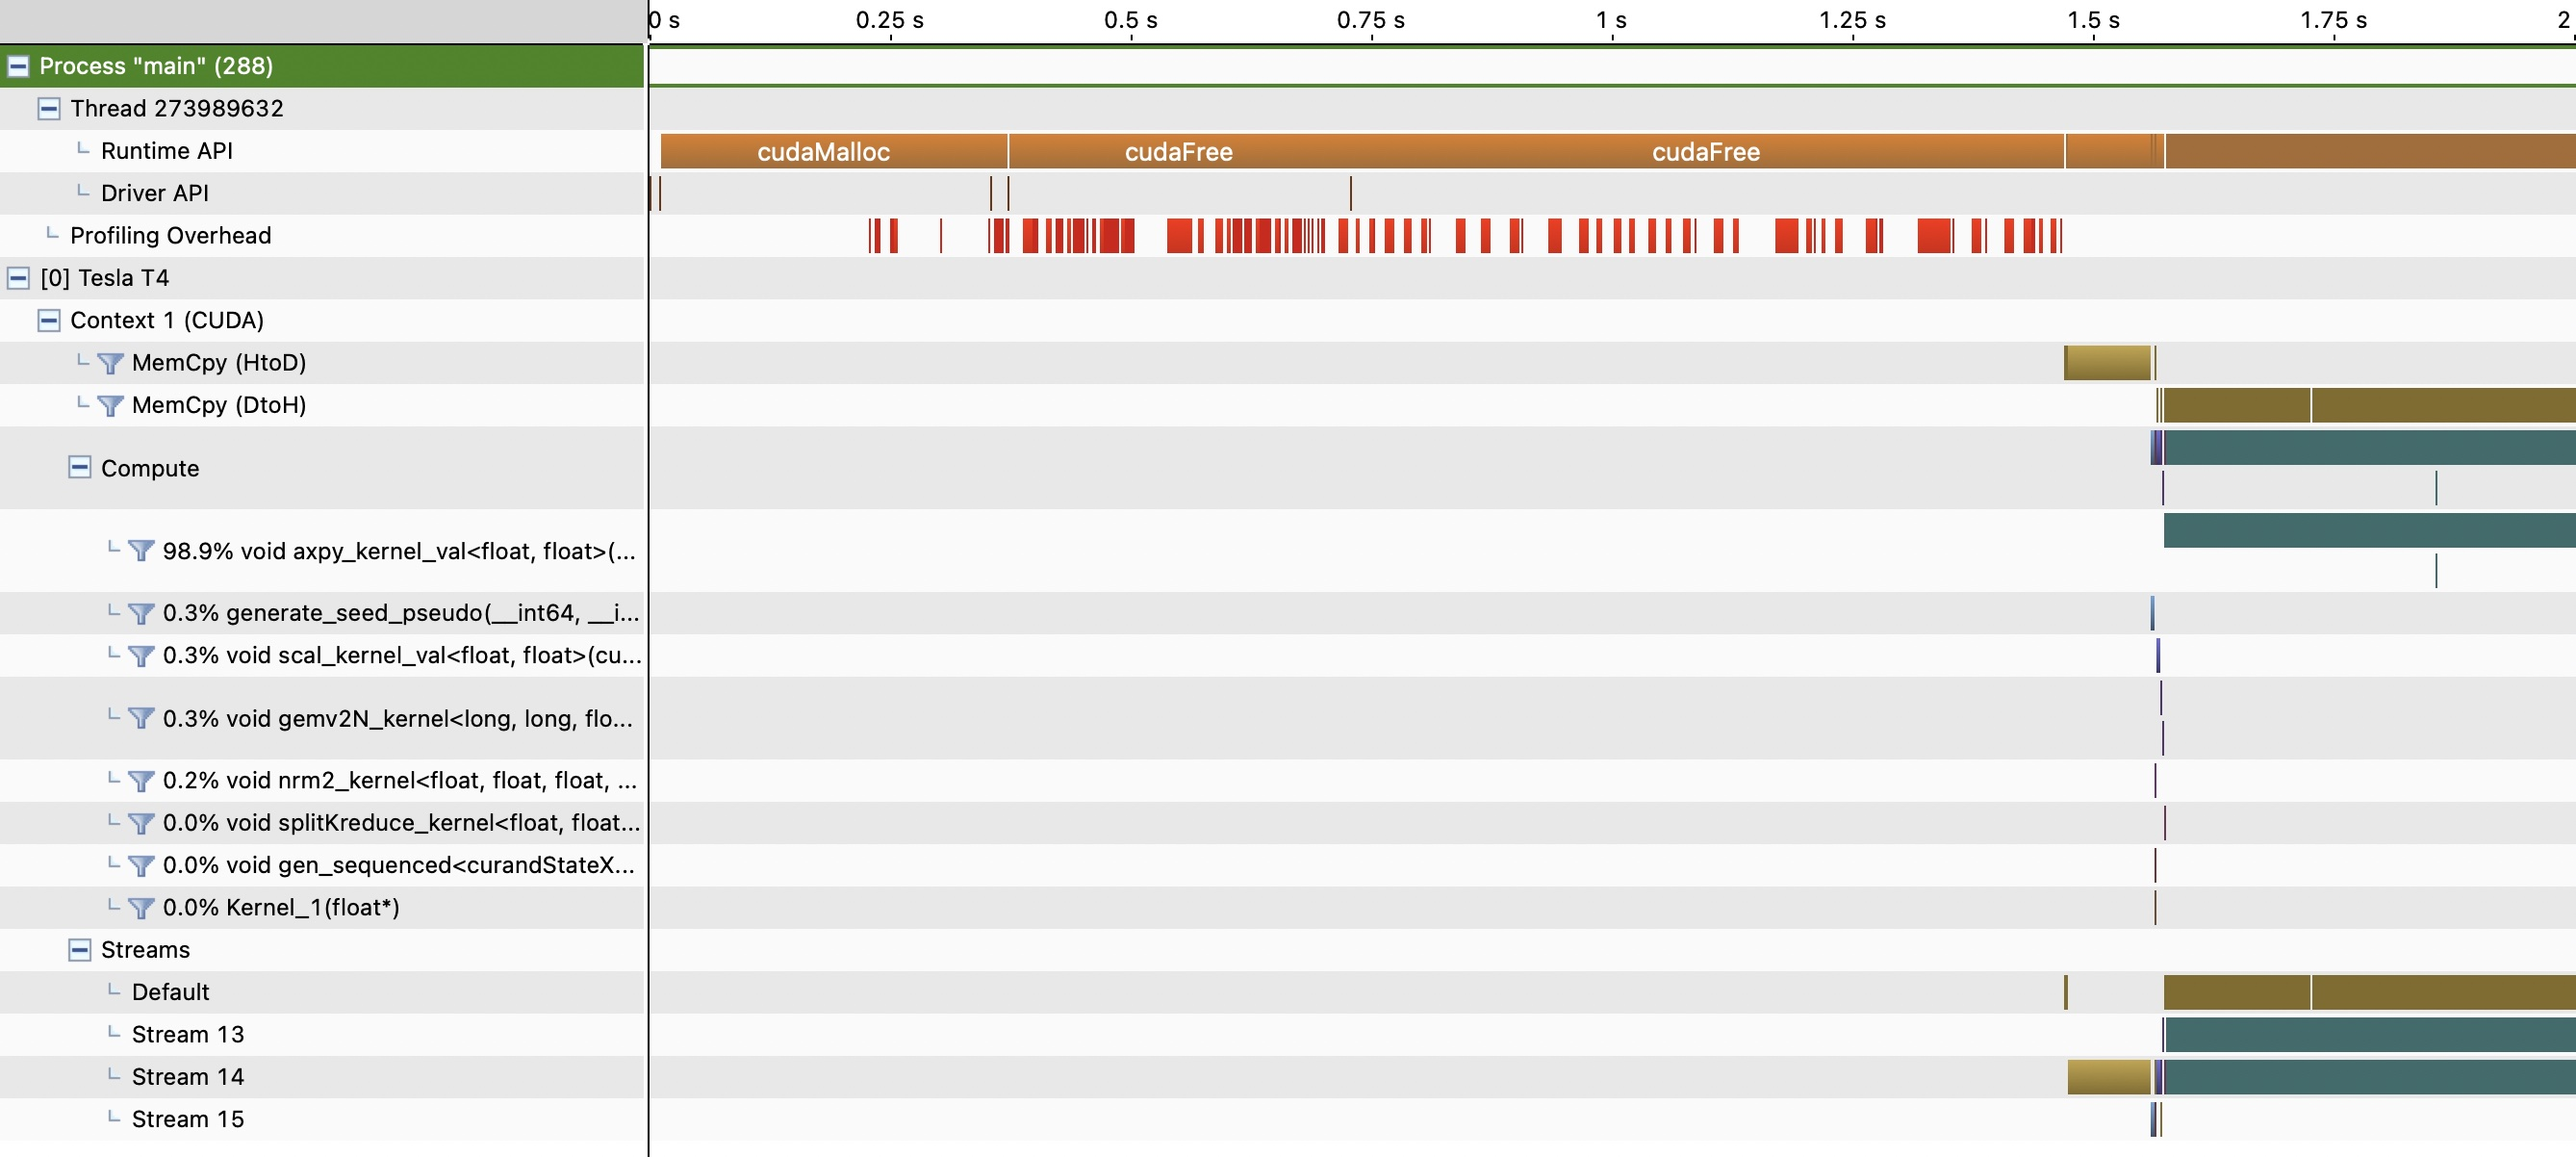

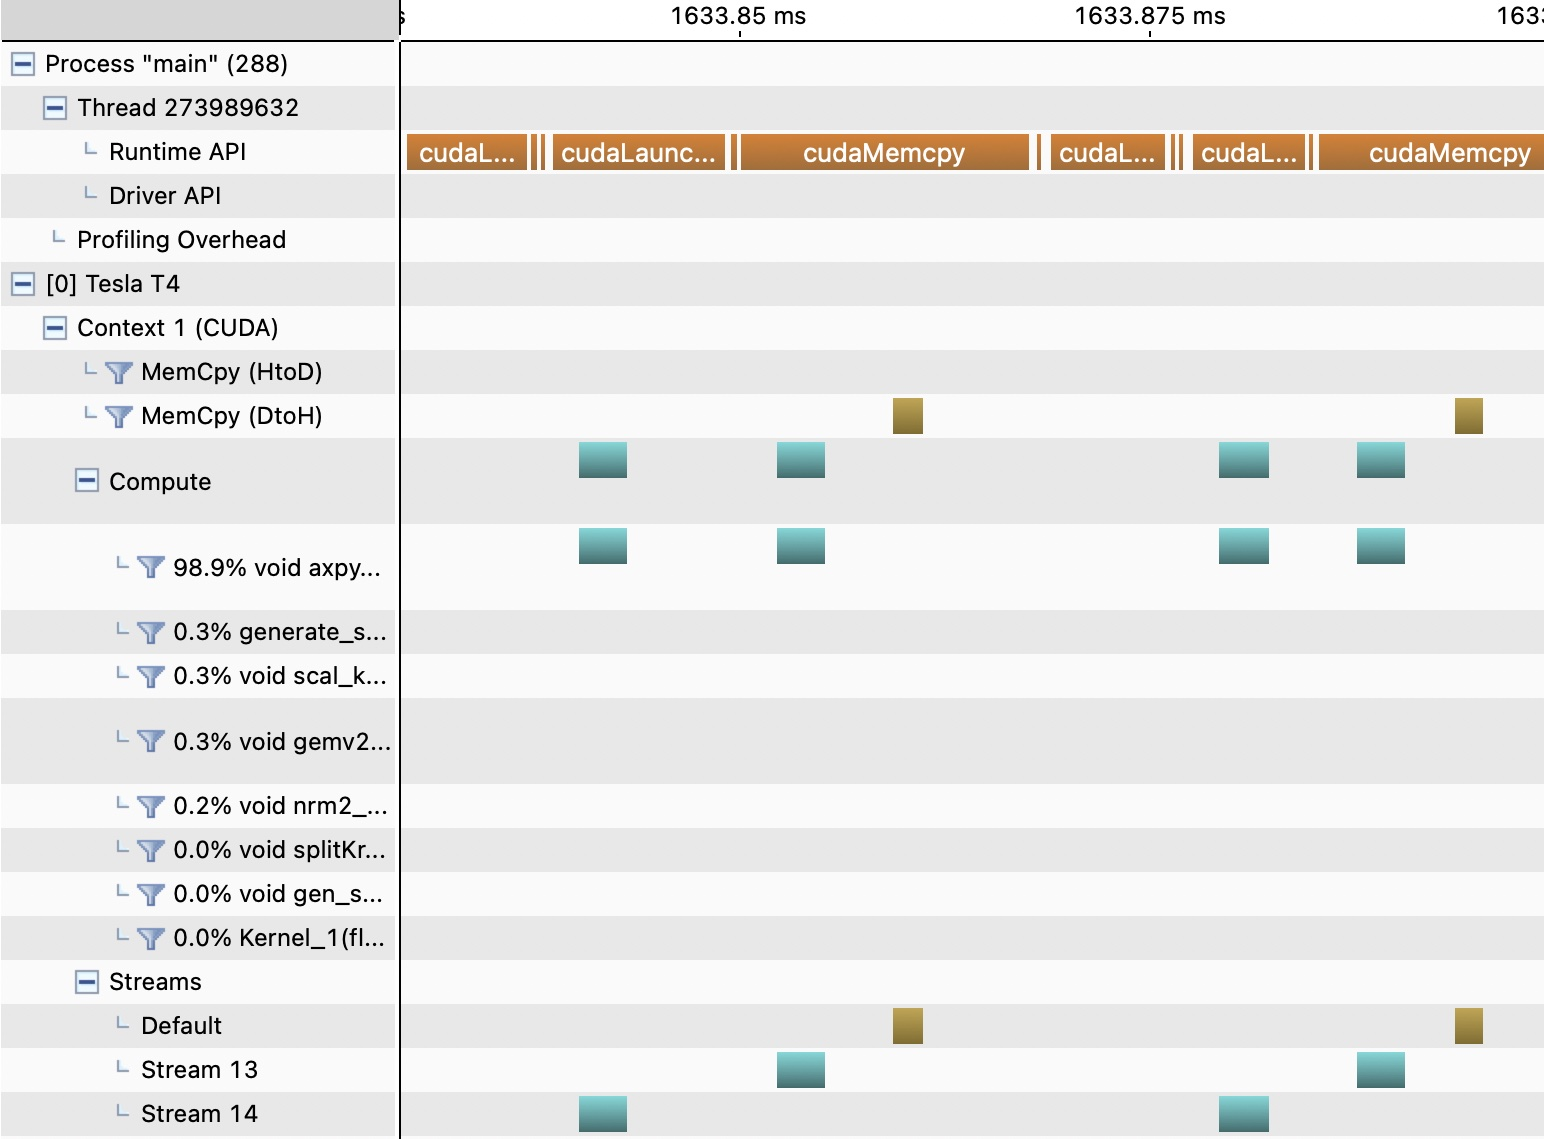

nvprof of CUDA C + BLAS

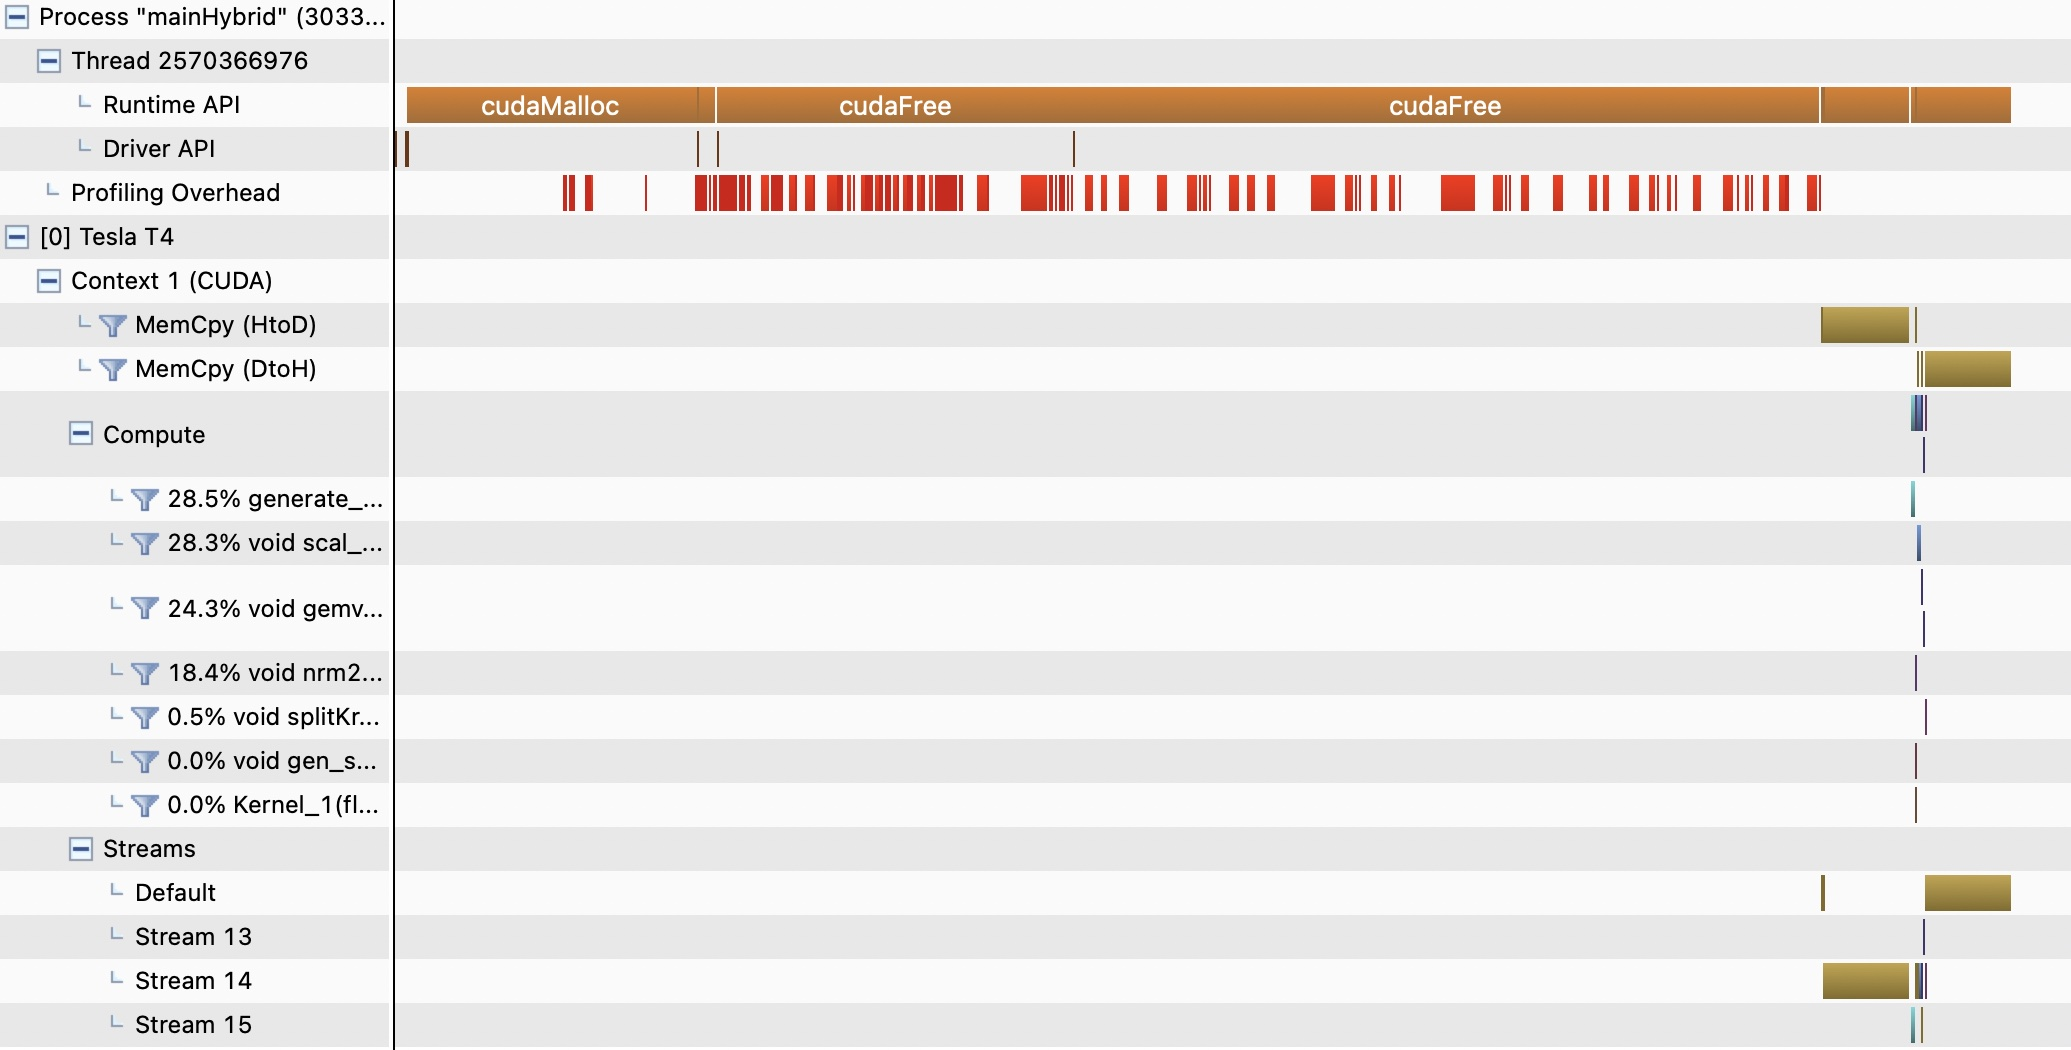

### Between single fuctions

#### numpy - cupy (Thetas generation)

In [ ]:
import numpy
import cupy

def np(W):
  n = W.shape[0]
  numpy.random.seed(0)

  W_ = W / numpy.linalg.norm(W)
  
  theta = 2*numpy.pi*numpy.random.rand(n)
  sin_t = numpy.sin(theta)
  cos_t = numpy.cos(theta)

  A = numpy.dot(W, cos_t)
  B = numpy.dot(W, sin_t) 

def cp(W):
  n = W.shape[0]
  cupy.random.seed(0)

  W_ = cupy.array(W)
  W_ = W_ / numpy.linalg.norm(W_)
  cupy.asnumpy(W_)

  theta = 2*cupy.pi*cupy.random.rand(n)
  cupy.asnumpy(theta)

  sin_t = cupy.sin(theta)
  cupy.asnumpy(sin_t)
  
  cos_t = cupy.cos(theta)
  cupy.asnumpy(cos_t)
  
  A = cupy.dot(W_, cos_t)
  cupy.asnumpy(A)

  B = cupy.dot(W_, sin_t) 
  cupy.asnumpy(B)

In [ ]:
%%capture
n = 20

avg_time_of(np, ["Numpy", W_2])
avg_time_of(cp, ["Cupy", W_2])

In [ ]:
n = 10000

avg_time_of(np, ["Numpy", W])
avg_time_of(cp, ["Cupy", W])